In [13]:
%config InlineBackend.figure_format = "svg"

from meta import get_class_weights, Meta, to_numpy
from fitting import get_model, get_model_name
from sklearn.metrics import roc_auc_score
from dataprocessing import generate_tasks
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import torch
import json
import glob

# Load the model

In [2]:
def fetch_model(filepath):
    
    # Model architecture
    filename = filepath.split("/")[-1]
    name = filename[:-3]
    dropout = float(name[name.find("D")+len("D"):name.find("D")+5])
    sup_shots = int(name[name.find("K")+len("K"):name.rfind("Q")])
    que_shots = int(name[name.find("Q")+len("Q"):name.rfind("-H")])
    hidden_layers = name.split("F")[1:]
    hidden_layers = [int(hl) for hl in hidden_layers]

    # Arguments to create model
    config = get_model(hidden_layers, dropout)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Choose PyTorch device and load the model
    model = Meta(name, config, sup_shots, que_shots, device).to(device)
    model.load(filepath)
    
    return model

# Load the data

In [3]:
# Datapath and background file for data-files
datapath = "processed-data/"
bkg_file = datapath + "bkg.h5"

# Signal files for each task split
val_signals = ["hg3000_hq1200", "wohg_hq1000"]
test_signals = ["wohg_hq1400", "fcnc"]

# Add datapath and extention to files for each split
val_signals = [datapath + p + ".h5" for p in val_signals]
test_signals = [datapath + p + ".h5" for p in test_signals]

# Get metrics on the test data

In [4]:
def get_metrics(model, sup_task, que_task, total_steps):
    # Get total steps
    # total_steps = len(list(que_task["data"]))
    
    # Iterate the whole query dataloader
    roc_steps = 0
    metrics = {"roc": 0, "acc": 0, "loss": 0}
    for _ in tqdm(range(total_steps), total=total_steps, desc="Iterating task loader", leave=False):
        
        # Get support and query samples from task
        x_sup, w_sup, y_sup = next(sup_task["data"])
        sup_weights = get_class_weights(sup_task["weights"], y_sup)
        x_que, w_que, y_que = next(que_task["data"])
        que_weights = get_class_weights(que_task["weights"], y_que)

        # Normalize weights
        w_sup = w_sup / w_sup.sum() * w_sup.shape[0]
        w_que = w_que / w_que.sum() * w_que.shape[0]
        
        # Model prediction
        y_hat = model.predict(x_sup, w_sup, y_sup, x_que, sup_weights)
        
        # Get roc (try except if only one class is present in sample)
        try:
            metrics["roc"] += roc_auc_score(to_numpy(y_que), to_numpy(y_hat.round()), sample_weight=to_numpy(w_que))
            roc_steps += 1
        except:
            pass
        
        # Get accuracy and loss
        metrics["acc"] += (torch.eq(y_hat.round(), y_que) * w_que).sum().item() / y_hat.shape[0]
        metrics["loss"] += (F.binary_cross_entropy(y_hat, y_que, reduction="none") * w_que * que_weights).mean().item()
        
    # Average the metrics
    metrics["acc"] /= total_steps
    metrics["loss"] /= total_steps
    metrics["roc"] /= roc_steps    
    
    return metrics

In [5]:
# Defining arguments for metric retrieval
sup_shots_list = [5, 10, 25, 50, 100, 250, 500]
que_shots_list = [2 * sup_shots for sup_shots in sup_shots_list]
total_samples = 50000

# Initializations
metrics = {}
model_paths = list(glob.glob("models/*.pt"))
shots_list = zip(sup_shots_list, que_shots_list)
    
# Iterate all number of support and query shots to evaluate from
for sup_shots, que_shots in tqdm(shots_list, total=len(sup_shots_list), desc="Iterating number of shots"):

    # Generate tasks
    # val_tasks = generate_tasks(val_signals, bkg_file, sup_shots, que_shots)
    test_tasks = generate_tasks(test_signals, bkg_file, sup_shots, que_shots)

    # Add entry to metrics
    shot_name = f"{sup_shots}/{que_shots}"
    metrics[shot_name] = {}
        
        # Iterate all models
    for model_path in tqdm(model_paths, total=len(model_paths), desc="Iterating models", leave=False):

        # Fetch model
        model = fetch_model(model_path)
        model_name = f"{model.k_sup}/{model.k_que}"

        # Add entry to metrics dict
        metrics[shot_name][model_name] = {}

        # Iterate all test signals
        for signal in tqdm(test_tasks, total=len(test_tasks), desc="Iterating tasks", leave=False):

            # Get support sample
            sup_task, que_task = test_tasks[signal]["sup"], test_tasks[signal]["que"]
            x_sup, w_sup, y_sup = next(sup_task["data"])
            sup_weights = get_class_weights(sup_task["weights"], y_sup)

            # Get metrics for this models, shot and task
            total_steps = total_samples // sup_shots
            metrics[shot_name][model_name][signal] = get_metrics(model, sup_task, que_task, total_steps)

Iterating number of shots:   0%|          | 0/7 [00:00<?, ?it/s]

Populating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating models:   0%|          | 0/7 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/10000 [00:00<?, ?it/s]

Populating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating models:   0%|          | 0/7 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/5000 [00:00<?, ?it/s]

Populating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating models:   0%|          | 0/7 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/2000 [00:00<?, ?it/s]

Populating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating models:   0%|          | 0/7 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/1000 [00:00<?, ?it/s]

Populating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating models:   0%|          | 0/7 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/500 [00:00<?, ?it/s]

Populating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating models:   0%|          | 0/7 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/200 [00:00<?, ?it/s]

Populating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating models:   0%|          | 0/7 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

Iterating task loader:   0%|          | 0/100 [00:00<?, ?it/s]

## Save the metrics

Just as a safeguard not to lose them. Metric calculation takes a while.

In [6]:
def save_metrics(data, path):
    with open(path, "w") as f:
        json.dump(data, f)
        
def load_metrics(path):
    with open(path) as f:
        return json.load(f)

In [7]:
save_metrics(metrics, "metric_results.json")

## Plot the obtained metrics

In [27]:
def plot_cm(data, metric="roc", signal="fcnc"):
    
    # Get list of shots and models
    shots = sorted([key for key in data])
    models = sorted([key for key in data[shots[0]]])
    
    # Check if arguments are correct
    signals = [key for key in data[shots[0]][models[0]]]
    metrics = [key for key in data[shots[0]][models[0]][signals[0]]]
    if metric not in metrics:
        print(f"Choose a valid metric. Options are: {metrics}")
        return
    elif signal not in signals:
        print(f"Choose a valid signal. Options are: {signals}")
        return
    
    # Matrix of metrics
    matrix = [[data[shot][model][signal][metric] for model in data[shot]] for shot in data]
    matrix = np.array(matrix)
    
    # Create figure and image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(f"{metric} evaluation on {signal} signal")
    ax.imshow(matrix, cmap="Reds")
    ax.set_xlabel("Model Sup/Query training shots")
    ax.set_ylabel("Sup/Query evaluation shots")

    # Create ticks
    ax.set_xticks(np.arange(len(models)))
    ax.set_yticks(np.arange(len(shots)))
    ax.set_xticklabels(models)
    ax.set_yticklabels(shots)

    # Loop over data dimensions and create text annotations.
    for i in range(len(shots)):
        for j in range(len(models)):
            text = ax.text(j, i, f"{matrix[i, j]:.4f}", ha="center", va="center", color="black")

    # Plot
    fig.tight_layout()
    plt.show()

In [9]:
# Load metrics
metrics = load_metrics("metric_results.json")

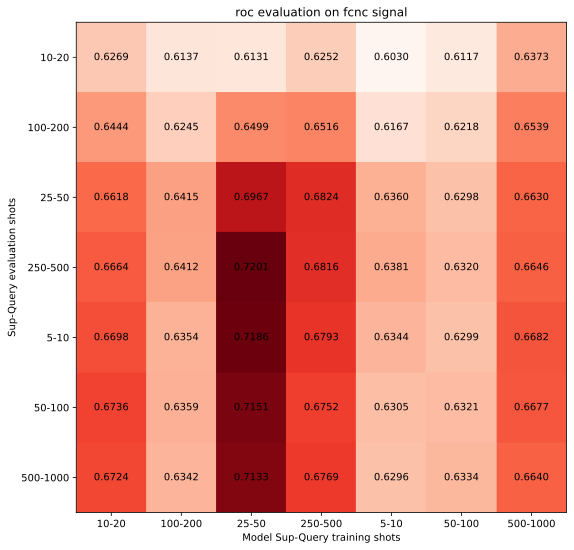

In [28]:
# Plot from the metrics dictionary
plot_cm(metrics, metric="roc", signal="fcnc")